## Importing Data

### Import required libraries

In [1]:
import numpy as np
from pylab import * # import some shortcuts to plotting functionality

### Import data from "pca_data.csv"

In [3]:
X = np.genfromtxt('pca_data.csv', delimiter=',')
X = X[1:,:] # Remove the headers

### Find index of good meat/bad meat/good berries

#### Key for status, food and batch column values
Status: Good = 1, Bad = 0;

Food: Meat = 1, Berries = 0;

Batch: A = 1, B = 2, C = 3, D = 4, E = 5;

In [4]:
status = X[:,5]
food = X[:, 6]
batch = X[:, 7]

gm = [index for index, value in enumerate(status) if (status[index] == 1 and food[index] == 1)]
bm = [index for index, value in enumerate(status) if (status[index] == 0 and food[index] == 1)]
gb = [index for index, value in enumerate(status) if (status[index] == 1 and food[index] == 0)]
bb = [index for index, value in enumerate(status) if (status[index] == 0 and food[index] == 0)]

good = gm + gb
bad = bm + bb

all_index = gm + bm + gb + bb
X = X[all_index,:]

## Principal Component Analysis


#### PCA Theory

What PCA tries to do, is to find linear combinations of the attributes which, when used as new variables, allow the best separation of the data. Another way of saying the same thing is to find new variables whose values "explain" the most variation in the data, in order. Yet another way is to imagine the data as an ellipsoidal cloud in the higher dimensional attribute-space, and finding the orthogonal axes of this ellipsoid, in order, first the "longest" axis, then the second longest, etc. 

A formal way of saying this is that first we are looking for a vector $w_1$, such that the data projected onto this vector has the largest variance, i.e. 

$$
w_1 = {\rm arg} \max_{w} \sum_i^N (X_i \cdot w)^2
$$

where $X_i$ is the vector corresponding to the attributes of patient $i$. This is equivalent to maximising 

$$
wX^T Xw
$$

which is achieved by the eigenvector of $X^T X$ with the largest eigenvalue. The second axis of the ellipsoid will be the eigenvector with the second largest eigenvalue, etc. 

Note that above we implicitly assumed that the mean of the data is zero along all attributes, so we will have to normalise the data to achieve this, i.e. subtract the mean value from each attribute. And since we are only interesting in finding the directions of the orthogonal axes, it is also customary to multiply each attribute by a scalar so that their variances are unity. 

### Normalising the sensor readings

In [5]:
def normalise(x):
    ndata,ndim = x.shape # obtain the number of rows and columns
    m= x.sum(axis=0)     # compute the mean along each column, and collect it into a vector
    #print m
    mean = m[np.newaxis,:]/ndata
    x0 = x - mean    # subtract the mean divided by the number of rows from each element
                                   # the "np.newaxis" construct creates identical rows from the same mean value

    s = np.sqrt((x0**2).sum(axis=0)/ndata) # now compute the standard deviation of each column
    #print x
    #print s
    ss = np.array([ tmp if tmp != 0 else 1 for tmp in s]) # if the standard deviation is zero, replace it with 1
                                                       # to avoid division by zero error
    x00 = x0 / ss[np.newaxis,:]    # divide each element by the corresponding standard deviation
    return x00, mean[0], ss                    # return the normalised data matrix

In [6]:
X0, m , ss = normalise(X[:,:4]) # we only normalise the attributes

### Computing the eigenvalues and eigenvectors of $X^T X$

In [7]:
# There are several ways to multiply matrices, depending on how they are created. 
# in the current case, using the matmul() function is one way. 
XTX = np.matmul(np.transpose(X0), X0) 

In [8]:
evals,evecs = np.linalg.eigh(XTX)

In [9]:
evals

array([  2.95475214,  17.73972525,  58.89016909, 176.41535351])

In [10]:
evecs

array([[-0.04464964, -0.80549952, -0.27850921, -0.52116174],
       [ 0.73342482,  0.2123804 ,  0.31889604, -0.56150504],
       [-0.67044968,  0.20723324,  0.48486883, -0.5219711 ],
       [ 0.10291585, -0.51295174,  0.76527129,  0.37503159]])

### Projection onto PC axes

In [11]:
X1 = np.matmul(X0,evecs[:,-1])
X2 = np.matmul(X0,evecs[:,-2])
X3 = np.matmul(X0,evecs[:,-3])

#### PC-2 against PC-1 plot

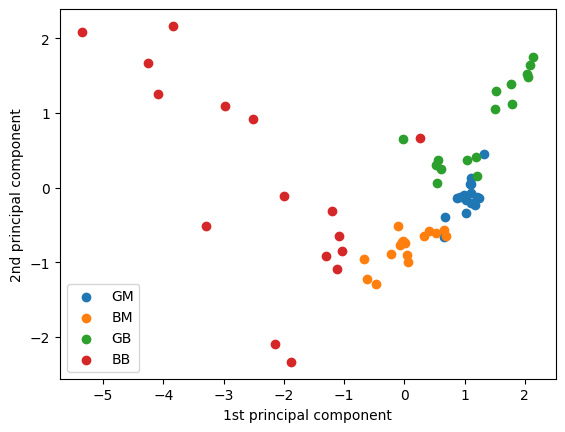

In [12]:
scatter(X1[gm], X2[gm])
scatter(X1[bm], X2[bm])
scatter(X1[gb], X2[gb])
scatter(X1[bb], X2[bb])
legend(["GM", "BM", "GB", "BB"])

xlabel("1st principal component")
ylabel("2nd principal component")
plt.show()

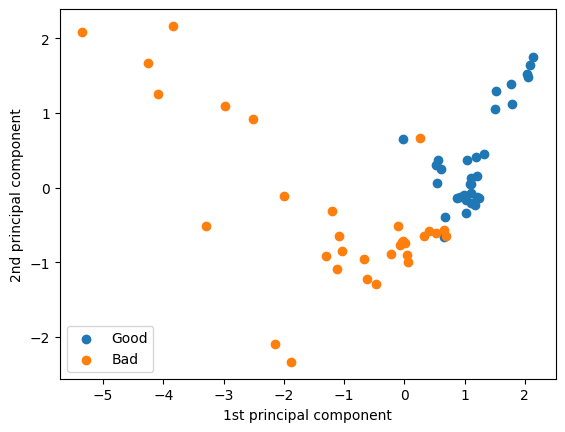

In [13]:
scatter(X1[good], X2[good])
scatter(X1[bad], X2[bad])
legend(["Good", "Bad"])

xlabel("1st principal component")
ylabel("2nd principal component")
plt.show()


#### Cluster centroids

In [14]:
good_mean = np.array([np.mean(X1[good]), np.mean(X2[good])])
bad_mean = np.array([np.mean(X1[bad]), np.mean(X2[bad])])

## Useful outputs of this notebook

### Mean and standard deviation for standardization

In [15]:
print(f"The mean values are {m}")
print(f"The standard deviations are {ss}")

The mean values are [565.765625 112.328125  28.203125 198.34375 ]
The standard deviations are [57.631844   83.09822025 15.09364486 29.56677757]


### PC-1, PC-2 and PC-3 axes

In [16]:
for i in range(3):
    print(f"PC{i+1} axis is {evecs[:,-(i+1)]}, with corresponding eigenvalue {evals[-(i+1)]:.1f}")

PC1 axis is [-0.52116174 -0.56150504 -0.5219711   0.37503159], with corresponding eigenvalue 176.4
PC2 axis is [-0.27850921  0.31889604  0.48486883  0.76527129], with corresponding eigenvalue 58.9
PC3 axis is [-0.80549952  0.2123804   0.20723324 -0.51295174], with corresponding eigenvalue 17.7


### Centroids of clusters

In [17]:
categories = ["good", "bad"]
for category in categories:
    print(f"The centroid for cluster {category} is {locals()[category+'_mean']}")

The centroid for cluster good is [1.16189819 0.36969963]
The centroid for cluster bad is [-1.16189819 -0.36969963]


## Categorisation

### Inference (with 4 data points only)

In [18]:
PC1 = evecs[:,-1]
PC2 = evecs[:,-2]

In [19]:
gm_sample = [533, 57, 18, 205]
bm_sample = [577, 90, 21, 178]
gb_sample = [507, 67, 24, 240]
bb_sample = [658, 131, 28, 188]

def inference4(co2, ammonia, ethanol, methane):
    data = np.array([co2, ammonia, ethanol, methane])
    data = (data-m)/ss
    print(data)
    x = np.matmul(data, evecs[:,-1])
    y = np.matmul(data, evecs[:,-2])

    print(x,y)
    data_point = np.array([x, y])
    dg = np.linalg.norm(data_point - good_mean)
    db = np.linalg.norm(data_point - bad_mean)

    if dg < db:
        print("good")
    else:
        print("bad")
    return data_point

gm_pt = inference4(*gm_sample)
bm_pt = inference4(*bm_sample)
gb_pt = inference4(*gb_sample)
bb_pt = inference4(*bb_sample)

[-0.56853334 -0.665816   -0.67598815  0.22512599]
1.107432506162877 -0.20946744760257524
good
[ 0.19493346 -0.26869559 -0.477229   -0.68806112]
0.04033715044696762 -0.8979236105013085
bad
[-1.01967282 -0.54547648 -0.27846985  1.40888705]
1.5114326287969875 1.0531974365454744
good
[ 1.60040645  0.22469645 -0.01345765 -0.34984367]
-1.084416728845003 -0.6483236352472488
bad


## Plotting sensor readings

### Plotting data

[ 0.24698802 -0.55751044 -0.0797107  -0.78952635]
-0.07016643025736871 -0.8894273941316737
bad


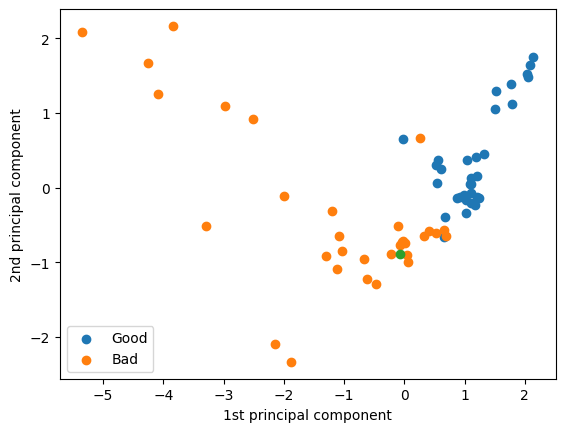

In [20]:
data = "580 66.00 27.00 175.00".split()
data = [float(val) for val in data]
data_pt = inference4(*data)

scatter(X1[good], X2[good])
scatter(X1[bad], X2[bad])
legend(["Good", "Bad"])

scatter(data_pt[0], data_pt[1])

xlabel("1st principal component")
ylabel("2nd principal component")
plt.show()